## packages

In [174]:
# import libraries
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
%load_ext rpy2.ipython

%R library(circlize)
%R library(RColorBrewer)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['RColorBrewer', 'circlize', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U12')

## website scraping

In [113]:
shipsDate = []
for i in range(1,776):
    #quote_page = f"https://archiveofourown.org/tags/Percy%20Jackson%20and%20the%20Olympians%20*a*%20Related%20Fandoms%20-%20All%20Media%20Types/works?commit=Sort+and+Filter&page={i}&utf8=%E2%9C%93&work_search%5Bcomplete%5D=&work_search%5Bcrossover%5D=F&work_search%5Bdate_from%5D=&work_search%5Bdate_to%5D=&work_search%5Bexcluded_tag_names%5D=&work_search%5Blanguage_id%5D=&work_search%5Bother_tag_names%5D=&work_search%5Bquery%5D=&work_search%5Bsort_column%5D=revised_at&work_search%5Bwords_from%5D=&work_search%5Bwords_to%5D="
    t0 = time.time()
    time.sleep(5)
    page = requests.get(quote_page)
    response_delay = time.time() - t0
    soup = BeautifulSoup(page.content, "html.parser")
    
    date = soup.find('p', attrs={'class': 'datetime'})
    date = date.text.strip()
    
    ships = soup.find_all('li', attrs={'class': 'relationships'})
    
    shipsList = []
    for i in range(0,len(ships)):
        shipsList.append(ships[i].text.strip())

    for i in shipsList:
        shipsDate.append([i,date])
    

NameError: name 'quote_page' is not defined

In [ ]:
df = pd.DataFrame(shipsDate, columns= ["Ship","Date"])

In [ ]:
df.to_csv('output1.csv')

## start here after scraping

In [134]:
df = pd.read_csv('output1.csv')

In [135]:
pd.isnull(df).any(1).nonzero()[0]

array([], dtype=int64)

In [136]:
df = df[df['Ship'].str.contains('/')]

In [137]:
df['Ship'] = df['Ship'].str.replace(r"\(.*\)","")

In [138]:
individuals = df["Ship"].str.split("/", expand = True) 

personColumns = []
for i in range(0,7):
    df[f"Person {i+1}"] = individuals[i]
    personColumns.append(f"Person {i+1}")

df = df.reset_index(drop=True)

In [139]:
df.head()

,Ship,Date,Person 1,Person 2,Person 3,Person 4,Person 5,Person 6,Person 7
0,Annabeth Chase/Percy Jackson,02 Apr 2019,Annabeth Chase,Percy Jackson,None,None,None,None,None
1,Nico di Angelo/Pollux,02 Apr 2019,Nico di Angelo,Pollux,None,None,None,None,None
2,Annabeth Chase/Percy Jackson,02 Apr 2019,Annabeth Chase,Percy Jackson,None,None,None,None,None
3,Annabeth Chase/Piper McLean,02 Apr 2019,Annabeth Chase,Piper McLean,None,None,None,None,None
4,Aphrodite/Ares,02 Apr 2019,Aphrodite,Ares,None,None,None,None,None


In [140]:
dfAnnabeth = df[df['Person 1'].str.contains("Annabeth")].copy()
dfAnnabeth['Person 1'].unique()
dfAnnabeth.loc[dfAnnabeth['Person 1'].str.contains('Annabeth', case=False), 'Person 1'] = 'Annabeth Chase'

In [141]:
mainCharacters = ['Percy', 'Annabeth', 'Grover', 'Leo' , 'Nico', 'Jason', 'Thalia', 
                  'Rachel', 'Bianca', 'Calypso' ,'Charles', 'Clarisse','Ethan',
                 'Juniper','Luke','Selena','Zo','Tyson','Will','Travis','Connor',
                 'Frank','Hazel','Octavian','Piper','Reyna','Magnus','Sam','Sally','Silena','Chris',
                  'Hylla','Drew','Frederick','Alex','Katie','Lou']
gods = ['Aphrodite','Ares','Athena','Chiron','Poseidon','Hera',
        'Hephaestus','Demeter','Zeus','Hades','Apollo','Artemis','Hestia','Hedge',
        'Persephone', 'Diana']

In [142]:
for i in personColumns:
    for j in range(0,len(mainCharacters)):
        df.loc[df[i].str.contains(mainCharacters[j], case=False, na=False), i] = mainCharacters[j]
        
    for k in range(0,len(gods)):
        df.loc[df[i].str.contains(gods[k], case=False, na=False), i] = gods[k]

    df.loc[df[i].str.contains('Original', case=False, na=False), i] = 'OC'

    df.loc[df[i].str.contains('Reader', case=False, na=False), i] = 'Reader'
    df.loc[df[i].str.contains('you', case=False, na=False), i] = 'Reader'

In [144]:
#threshold = 20
#toRemove = value_counts[value_counts <= threshold].index
#for i in personColumns:
#    df[i].replace(toRemove, np.nan, inplace=True)

In [154]:
value_counts = df[personColumns].stack().value_counts()

In [146]:
top50 = value_counts.index[:50].tolist()

In [147]:
dfAdj = pd.DataFrame(index=top50, columns=top50)
dfAdj = dfAdj.fillna(0) # with 0s rather than NaNs

In [148]:
dfAdj.head()

,Nico,Percy,Will,Annabeth,Jason,Piper,Leo,Frank,Hazel,Reyna,...,Lou,Magnus,Hera,Alabaster Torrington,Ares,Cecil Markowitz,Hermes,Aphrodite,Sadie Kane,Kronos
Nico,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Will,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Annabeth,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Jason,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [149]:
for i in range(df.shape[0]):
    if df.at[i,'Person 1'] in top50 and df.at[i,'Person 2'] in top50:
        indexPerson = df.at[i,'Person 1']
        columnPerson = df.at[i,'Person 2']
        dfAdj.at[indexPerson, columnPerson] += 1

In [150]:
range(df.shape[1])

range(0, 9)

In [151]:
dfTest = pd.DataFrame(index=top50, columns=top50)
dfTest = dfTest.fillna(0)

In [152]:
df.at[3,'Person 1'] in top50

True

In [153]:
dfAdj

,Nico,Percy,Will,Annabeth,Jason,Piper,Leo,Frank,Hazel,Reyna,...,Lou,Magnus,Hera,Alabaster Torrington,Ares,Cecil Markowitz,Hermes,Aphrodite,Sadie Kane,Kronos
Nico,0,589,2233,1,327,1,96,4,2,3,...,0,0,0,3,0,0,1,0,0,1
Percy,36,1,25,78,16,14,20,3,0,17,...,0,0,0,5,1,0,1,0,0,16
Will,62,1,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Annabeth,8,1514,0,0,24,167,3,0,4,60,...,0,0,0,0,0,0,0,0,0,0
Jason,10,397,24,0,0,738,95,3,0,63,...,0,0,2,0,0,0,0,0,0,0
Piper,1,0,0,4,32,0,38,2,0,40,...,0,0,0,0,0,0,0,0,0,0
Leo,6,4,2,0,9,1,0,27,2,0,...,0,1,0,0,0,0,0,0,0,0
Frank,0,0,0,0,1,0,2,0,15,0,...,0,0,0,0,0,0,0,0,0,0
Hazel,0,0,0,0,0,13,76,529,0,0,...,0,0,0,0,0,0,0,0,1,0
Reyna,0,0,1,0,2,1,13,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
dfTop15 = dfAdj.iloc[:15]
dfTop15 = dfTop15[top50[:15]]

In [169]:
dfTop15

,Nico,Percy,Will,Annabeth,Jason,Piper,Leo,Frank,Hazel,Reyna,Calypso,Luke,OC,Thalia,Reader
Nico,0,589,2233,1,327,1,96,4,2,3,0,1,25,7,18
Percy,36,1,25,78,16,14,20,3,0,17,0,9,31,2,29
Will,62,1,0,0,0,0,7,0,0,0,0,0,8,0,4
Annabeth,8,1514,0,0,24,167,3,0,4,60,0,5,11,10,6
Jason,10,397,24,0,0,738,95,3,0,63,0,0,13,0,14
Piper,1,0,0,4,32,0,38,2,0,40,0,0,0,0,4
Leo,6,4,2,0,9,1,0,27,2,0,17,2,22,1,13
Frank,0,0,0,0,1,0,2,0,15,0,1,0,3,0,11
Hazel,0,0,0,0,0,13,76,529,0,0,0,0,0,0,3
Reyna,0,0,1,0,2,1,13,1,0,0,1,0,4,3,2


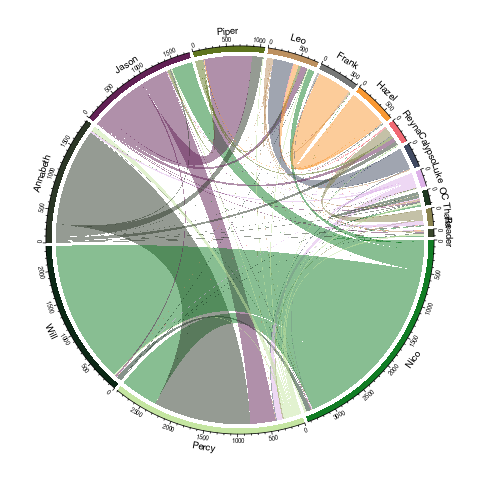

In [209]:
%R -i dfTop15
%R chordDiagram(dfTop15, transparency = 0.4, grid.col = "midnightblue", col = colorRamp2(seq(0, 2300, 100), brewer.pal(20, "Blues")))
%R circos.clear()